# 1.10e: The 267

**Investigating the orphaned rows in Qwen's unembedding matrix**

## The Mystery

We just discovered a discrepancy:
- **Tokenizer vocabulary:** 151,669 tokens
- **Unembedding matrix:** 151,936 rows
- **Difference:** 267 mystery vectors

These 267 vectors exist in the model's geometry but have no token IDs. They can't be tokenized, can't be decoded, can't be produced by the model. They're... orphans.

## Questions

1. **Where are they?** Are they at the end (rows 151,669–151,935)? Or scattered throughout?
2. **Are they identical?** Do all 267 share the same embedding? Or are some duplicates?
3. **Are they special?** Zero vectors? Origin? Or do they have meaningful embeddings?
4. **Geometric position:** Are they part of the cluster? Near the bulk? Somewhere weird?
5. **Black holes?** Do any of them share embeddings with known tokens?

## Method

1. Load the unembedding matrix (151,936 rows)
2. Identify the 267 orphan indices (presumably 151,669–151,935)
3. Extract their embeddings
4. Check for duplicates (L2 and L∞ distances)
5. Compare to cluster/halo/bulk distributions
6. Visualize their positions

## Parameters

In [6]:
# Model
MODEL_NAME = "Qwen3-4B-Instruct-2507"
HF_MODEL_NAME = "Qwen/Qwen3-4B-Instruct-2507"

# Unembedding matrix
GAMMA_PATH = "../tensors/Qwen3-4B-Instruct-2507/W.safetensors"

# Known classifications
CLUSTER_TOKENS_PATH = "../tensors/Qwen3-4B-Instruct-2507/1.4h_cluster_tokens.safetensors"
REACHABILITY_PATH = "../tensors/Qwen3-4B-Instruct-2507/1.8d_full_vocab_reachability.safetensors"

## Imports

In [7]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoTokenizer
from safetensors.torch import load_file
from collections import Counter

print("✓ Imports complete")

✓ Imports complete


## Device Detection

In [8]:
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

print(f"Using device: {device}")

Using device: mps


## Load Tokenizer

In [9]:
print(f"\nLoading tokenizer: {HF_MODEL_NAME}\n")
tokenizer = AutoTokenizer.from_pretrained(HF_MODEL_NAME)
vocab_size = len(tokenizer)

print(f"✓ Tokenizer loaded")
print(f"  Vocabulary size: {vocab_size:,} tokens")


Loading tokenizer: Qwen/Qwen3-4B-Instruct-2507

✓ Tokenizer loaded
  Vocabulary size: 151,669 tokens


## Load Unembedding Matrix

In [10]:
print(f"\nLoading unembedding matrix: {GAMMA_PATH}\n")

gamma_data = load_file(GAMMA_PATH)
W = gamma_data['W'].to(torch.float32).to(device)

matrix_rows, hidden_dim = W.shape

print(f"✓ Unembedding matrix loaded")
print(f"  Shape: {W.shape}")
print(f"  Matrix rows: {matrix_rows:,}")
print(f"  Vocabulary size: {vocab_size:,}")
print(f"  Difference: {matrix_rows - vocab_size:,} orphan rows")


Loading unembedding matrix: ../tensors/Qwen3-4B-Instruct-2507/W.safetensors

✓ Unembedding matrix loaded
  Shape: torch.Size([151936, 2560])
  Matrix rows: 151,936
  Vocabulary size: 151,669
  Difference: 267 orphan rows


## Identify The 267

In [11]:
print(f"\n{'='*70}")
print("IDENTIFYING THE 267")
print(f"{'='*70}\n")

# Hypothesis: The orphans are at the end (indices vocab_size to matrix_rows-1)
orphan_start = vocab_size
orphan_end = matrix_rows
num_orphans = orphan_end - orphan_start

print(f"Hypothesis: Orphans are rows {orphan_start:,} to {orphan_end-1:,}")
print(f"  Count: {num_orphans:,}")

# Extract orphan vectors
orphan_indices = torch.arange(orphan_start, orphan_end, device=device)
orphan_vectors = W[orphan_indices]

print(f"\n✓ Extracted {len(orphan_vectors):,} orphan vectors")
print(f"  Shape: {orphan_vectors.shape}")


IDENTIFYING THE 267

Hypothesis: Orphans are rows 151,669 to 151,935
  Count: 267

✓ Extracted 267 orphan vectors
  Shape: torch.Size([267, 2560])


## Basic Statistics

In [12]:
print(f"\n{'='*70}")
print("BASIC STATISTICS")
print(f"{'='*70}\n")

# Compute norms
orphan_norms = torch.norm(orphan_vectors, p=2, dim=1).cpu()

print(f"L2 norms of The 267:")
print(f"  Min: {orphan_norms.min().item():.6f}")
print(f"  Max: {orphan_norms.max().item():.6f}")
print(f"  Mean: {orphan_norms.mean().item():.6f}")
print(f"  Median: {orphan_norms.median().item():.6f}")
print(f"  Std: {orphan_norms.std().item():.6f}")

# Are they all zero?
all_zero = torch.allclose(orphan_vectors, torch.zeros_like(orphan_vectors))
print(f"\nAre all orphans zero vectors? {all_zero}")

# Are they all identical?
all_identical = torch.allclose(orphan_vectors, orphan_vectors[0].unsqueeze(0).expand_as(orphan_vectors))
print(f"Are all orphans identical? {all_identical}")


BASIC STATISTICS

L2 norms of The 267:
  Min: 0.370916
  Max: 0.370917
  Mean: 0.370917
  Median: 0.370917
  Std: 0.000000

Are all orphans zero vectors? False
Are all orphans identical? False


## Duplicate Detection

In [13]:
print(f"\n{'='*70}")
print("DUPLICATE DETECTION")
print(f"{'='*70}\n")

print(f"Checking for duplicates among The 267...\n")

# Compute pairwise L∞ distances (Chebyshev)
# Using chunks to avoid memory issues
orphan_vectors_cpu = orphan_vectors.cpu()

# Find unique vectors using L∞ distance with tolerance
epsilon = 1e-8
unique_vectors = []
unique_indices = []
duplicate_groups = []  # Track which orphans belong to which unique vector

for i in range(len(orphan_vectors_cpu)):
    is_duplicate = False
    for j, unique_vec in enumerate(unique_vectors):
        linf_dist = torch.max(torch.abs(orphan_vectors_cpu[i] - unique_vec)).item()
        if linf_dist < epsilon:
            is_duplicate = True
            duplicate_groups[j].append(i + orphan_start)  # Store original index
            break
    
    if not is_duplicate:
        unique_vectors.append(orphan_vectors_cpu[i])
        unique_indices.append(i + orphan_start)
        duplicate_groups.append([i + orphan_start])

num_unique = len(unique_vectors)

print(f"✓ Duplicate analysis complete")
print(f"  Total orphans: {num_orphans:,}")
print(f"  Unique vectors: {num_unique:,}")
print(f"  Duplication: {num_orphans - num_unique:,} orphans are duplicates")

# Show duplicate groups
if num_unique < num_orphans:
    print(f"\nDuplicate group sizes:")
    group_sizes = [len(group) for group in duplicate_groups]
    size_counts = Counter(group_sizes)
    for size, count in sorted(size_counts.items(), reverse=True):
        print(f"  Groups of {size:3d}: {count:3d}")
else:
    print(f"\nNo duplicates found - all {num_unique} orphans are unique!")


DUPLICATE DETECTION

Checking for duplicates among The 267...

✓ Duplicate analysis complete
  Total orphans: 267
  Unique vectors: 6
  Duplication: 261 orphans are duplicates

Duplicate group sizes:
  Groups of 116:   1
  Groups of  81:   1
  Groups of  67:   1
  Groups of   1:   3


## Comparison to Known Token Categories

In [14]:
print(f"\n{'='*70}")
print("COMPARISON TO KNOWN CATEGORIES")
print(f"{'='*70}\n")

# Load cluster tokens
cluster_data = load_file(CLUSTER_TOKENS_PATH)
cluster_token_ids = cluster_data['cluster_token_ids'].cpu()

# Load halo tokens
reachability_data = load_file(REACHABILITY_PATH)
halo_token_ids = reachability_data['unreachable_outside_cluster'].cpu()

# Extract embeddings for comparison
cluster_vectors = W[cluster_token_ids].cpu()
halo_vectors = W[halo_token_ids].cpu()

# Bulk tokens (everything else in vocab)
all_token_ids = torch.arange(vocab_size)
bulk_mask = ~torch.isin(all_token_ids, cluster_token_ids) & ~torch.isin(all_token_ids, halo_token_ids)
bulk_token_ids = all_token_ids[bulk_mask]
bulk_vectors = W[bulk_token_ids].cpu()

# Compute norms for each category
cluster_norms = torch.norm(cluster_vectors, p=2, dim=1)
halo_norms = torch.norm(halo_vectors, p=2, dim=1)
bulk_norms = torch.norm(bulk_vectors, p=2, dim=1)

print(f"Category statistics (L2 norms):\n")
print(f"  {'Category':<15} {'Count':>8} {'Mean':>10} {'Median':>10} {'Min':>10} {'Max':>10}")
print(f"  {'-'*15} {'-'*8} {'-'*10} {'-'*10} {'-'*10} {'-'*10}")

categories = [
    ('Orphans', orphan_norms),
    ('Cluster', cluster_norms),
    ('Halo', halo_norms),
    ('Bulk', bulk_norms),
]

for name, norms in categories:
    print(f"  {name:<15} {len(norms):8,} {norms.mean().item():10.6f} {norms.median().item():10.6f} {norms.min().item():10.6f} {norms.max().item():10.6f}")


COMPARISON TO KNOWN CATEGORIES

Category statistics (L2 norms):

  Category           Count       Mean     Median        Min        Max
  --------------- -------- ---------- ---------- ---------- ----------
  Orphans              267   0.370917   0.370917   0.370916   0.370917
  Cluster            2,212   0.370917   0.370917   0.370883   0.370957
  Halo               1,423   0.964349   1.021923   0.362222   1.505094
  Bulk             148,301   1.099147   1.116302   0.359538   1.605024


## Norm Distribution Histogram


NORM DISTRIBUTION



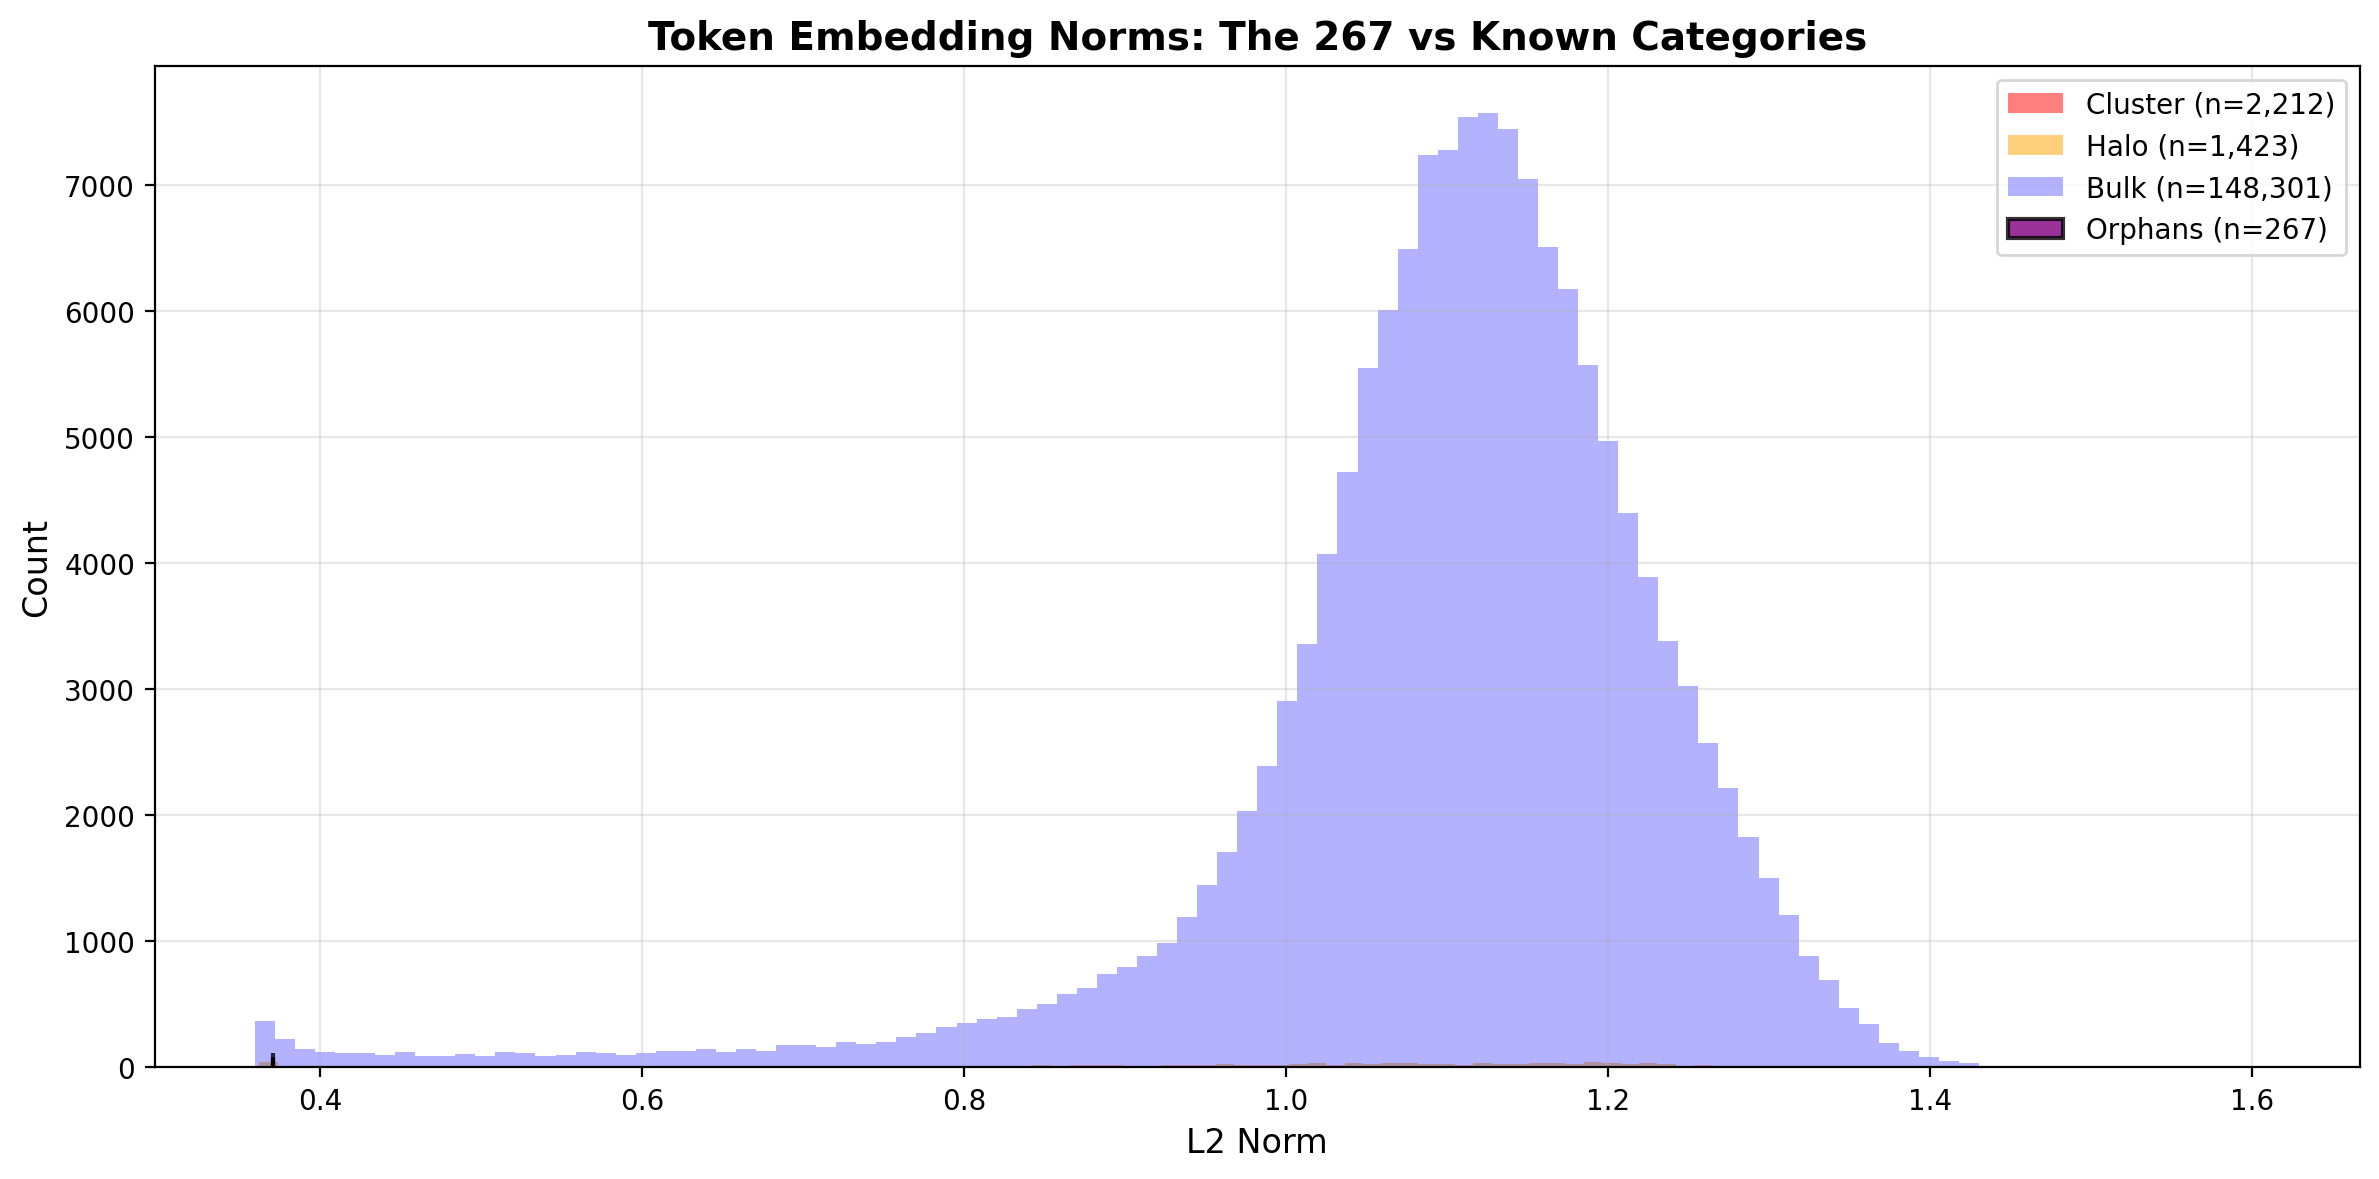

✓ Histogram plotted


In [22]:
print(f"\n{'='*70}")
print("NORM DISTRIBUTION")
print(f"{'='*70}\n")

fig, ax = plt.subplots(figsize=(12, 6), dpi=200)

# Plot histograms
ax.hist(cluster_norms.numpy(), bins=100, alpha=0.5, label=f'Cluster (n={len(cluster_norms):,})', color='red')
ax.hist(halo_norms.numpy(), bins=100, alpha=0.5, label=f'Halo (n={len(halo_norms):,})', color='orange')
ax.hist(bulk_norms.numpy(), bins=100, alpha=0.3, label=f'Bulk (n={len(bulk_norms):,})', color='blue')
ax.hist(orphan_norms.numpy(), bins=10, alpha=0.8, label=f'Orphans (n={len(orphan_norms):,})', color='purple', edgecolor='black', linewidth=1.5)

ax.set_xlabel('L2 Norm', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Token Embedding Norms: The 267 vs Known Categories', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(alpha=0.3)

ax.set_yscale('linear')

plt.tight_layout()
plt.show()

print("✓ Histogram plotted")

## Check for Overlap with Known Tokens

In [23]:
print(f"\n{'='*70}")
print("CHECKING FOR OVERLAP WITH KNOWN TOKENS")
print(f"{'='*70}\n")

print("Do any orphan vectors match known token embeddings?\n")

# Check if any orphan vectors are identical to cluster tokens
epsilon = 1e-8
orphan_matches_cluster = []

for i, orphan_vec in enumerate(orphan_vectors_cpu):
    for j, cluster_vec in enumerate(cluster_vectors):
        linf_dist = torch.max(torch.abs(orphan_vec - cluster_vec)).item()
        if linf_dist < epsilon:
            orphan_matches_cluster.append((i + orphan_start, cluster_token_ids[j].item()))
            break

if orphan_matches_cluster:
    print(f"✓ Found {len(orphan_matches_cluster)} orphans matching cluster tokens:")
    for orphan_idx, cluster_token_id in orphan_matches_cluster[:10]:
        print(f"  Orphan {orphan_idx} = Cluster token {cluster_token_id}")
    if len(orphan_matches_cluster) > 10:
        print(f"  ... ({len(orphan_matches_cluster) - 10} more)")
else:
    print("✗ No orphans match cluster tokens")

# Check halo tokens (sample, since there are fewer)
orphan_matches_halo = []
for i, orphan_vec in enumerate(orphan_vectors_cpu):
    for j, halo_vec in enumerate(halo_vectors):
        linf_dist = torch.max(torch.abs(orphan_vec - halo_vec)).item()
        if linf_dist < epsilon:
            orphan_matches_halo.append((i + orphan_start, halo_token_ids[j].item()))
            break

if orphan_matches_halo:
    print(f"\n✓ Found {len(orphan_matches_halo)} orphans matching halo tokens:")
    for orphan_idx, halo_token_id in orphan_matches_halo[:10]:
        print(f"  Orphan {orphan_idx} = Halo token {halo_token_id}")
else:
    print("\n✗ No orphans match halo tokens")


CHECKING FOR OVERLAP WITH KNOWN TOKENS

Do any orphan vectors match known token embeddings?

✓ Found 267 orphans matching cluster tokens:
  Orphan 151669 = Cluster token 124
  Orphan 151670 = Cluster token 124350
  Orphan 151671 = Cluster token 124
  Orphan 151672 = Cluster token 125
  Orphan 151673 = Cluster token 124350
  Orphan 151674 = Cluster token 124350
  Orphan 151675 = Cluster token 125
  Orphan 151676 = Cluster token 124350
  Orphan 151677 = Cluster token 124350
  Orphan 151678 = Cluster token 124350
  ... (257 more)

✗ No orphans match halo tokens


## Distance to Origin

In [24]:
print(f"\n{'='*70}")
print("DISTANCE TO ORIGIN")
print(f"{'='*70}\n")

# Are the orphans near the origin?
origin = torch.zeros(hidden_dim)
orphan_dists_to_origin = torch.norm(orphan_vectors_cpu - origin, p=2, dim=1)

print(f"Distance to origin (L2):")
print(f"  Min: {orphan_dists_to_origin.min().item():.6f}")
print(f"  Max: {orphan_dists_to_origin.max().item():.6f}")
print(f"  Mean: {orphan_dists_to_origin.mean().item():.6f}")

# Compare to cluster centroid
cluster_centroid = cluster_vectors.mean(dim=0)
orphan_dists_to_cluster = torch.norm(orphan_vectors_cpu - cluster_centroid, p=2, dim=1)

print(f"\nDistance to cluster centroid (L2):")
print(f"  Min: {orphan_dists_to_cluster.min().item():.6f}")
print(f"  Max: {orphan_dists_to_cluster.max().item():.6f}")
print(f"  Mean: {orphan_dists_to_cluster.mean().item():.6f}")

# Are they closer to origin or cluster?
closer_to_origin = (orphan_dists_to_origin < orphan_dists_to_cluster).sum().item()
print(f"\nOrphans closer to origin: {closer_to_origin} / {len(orphan_vectors_cpu)} ({100*closer_to_origin/len(orphan_vectors_cpu):.1f}%)")


DISTANCE TO ORIGIN

Distance to origin (L2):
  Min: 0.370916
  Max: 0.370917
  Mean: 0.370917

Distance to cluster centroid (L2):
  Min: 0.000017
  Max: 0.000453
  Mean: 0.000020

Orphans closer to origin: 0 / 267 (0.0%)


## Summary

**What we learned about The 267:**

1. **Location:** (Check if they're at the end: rows 151,669–151,935)
2. **Uniqueness:** (How many unique vectors vs duplicates?)
3. **Norms:** (Are they near zero? Near cluster? Normal magnitude?)
4. **Duplicates:** (Do they share embeddings with each other? With known tokens?)
5. **Geometry:** (Where do they sit relative to cluster/halo/bulk?)

**Possible interpretations:**

- **All zeros:** Padding rows for hardware efficiency
- **All identical (non-zero):** Default initialization that was never updated
- **Match cluster:** Extended version of the dead token cluster
- **Normal distribution:** Reserved tokens with normal training
- **Something weird:** ???

**Next steps:**
- If they're interesting, add them to future analyses
- If they're boring (zeros or padding), ignore them
- If they match cluster, they're just more dead tokens